## Welcome to the text analysis tutorial 👋!

The **goals** of the tutorial are to:

1. Understand the basics of text processing and the NLTK, Gensim, and spaCy libraries.
2. Explore topic modelling and its different flavours using TalTech paper abstracts from OpenAlex.

We will use paper abstracts from TalTech and discover various themes using topic modelling and. Below, you'll find useful resources for further reading and understanding.

#### Documentation

- [NLTK](https://www.nltk.org)
- [spaCy](https://spacy.io/api/doc)
- [tomotopy](https://bab2min.github.io/tomotopy/v/en/)

#### Repos

- [Uncle Steve's Big List of Text Analytics and NLP Resources](https://github.com/stepthom/text_mining_resources)

#### Papers

- [Gentzkow M. et al. (2019) - Text as Data](https://www.aeaweb.org/articles?id=10.1257/jel.20181020)

#### Books

- [Jurafsky, D. and Martin, J. (2023) - Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/)
- [Manning et al. (2008) - Introduction to Information Retrieval](https://nlp.stanford.edu/IR-book/information-retrieval-book.html)

We start off by importing essential libraries for data manipulation and visualizations. We also set some global configurations and initialize our data getter from the dap_taltech library.

In [ ]:
import os, warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import numpy as np
import pandas as pd

import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

from toolz import pipe
from typing import Dict, Sequence

from dap_taltech.utils.data_getters import DataGetter
from dap_taltech import logger

from tqdm import tqdm
tqdm.pandas()

os.environ["TOKENIZERS_PARALLELISM"] = "false"
alt.data_transformers.enable('default', max_rows=None)

Using the getter, we load articles related to TalTech. We then clean our data by removing any articles that do not contain an abstract, citation count, or year counts. We reset our dataframe's index for good measure.

In [ ]:
getter = DataGetter(local=True)
data = getter.get_oa_articles(institution="TT")
data.dropna(subset=['abstract', 'cited_by_count', 'counts_by_year'], inplace=True)
data.reset_index(drop=True, inplace=True)

#### Exploring the data

Let's begin by exploring our data to understand its structure and content better. We're looking at the different column types and the first few rows of our dataset.

In [ ]:
data.info()

In [ ]:
data.head(2)

In the next set of cells, we will be preparing our data for visualization, showing how to deal with nested dictionary objects in pandas Series. 

🔥**Note**🔥: Some of these are relatively slow, so by default they appear as raw code. Convert them to Python and run them to plot the figures.

As a first exmaple, let's count the number of publications per year and compute the log-scaled citation counts. The utility function `hist_plot` will then be used to display the distribution of publications and citations.

In [ ]:
# Prepare the data for the first plot
publications_over_time = data['publication_date'].dt.year.value_counts().reset_index()
publications_over_time.columns = ['Year', 'Number of Publications']
publications_over_time = publications_over_time.sort_values('Year')

# Prepare the data for the second plot
citations = data['cited_by_count'].apply(lambda x: np.log10(x + 1)).reset_index()
citations.columns = ['index', 'Number of Citations (Log Scale)']

We explode the counts_by_year column to expose the nested citation count data for each year. We then proceed to filter out rows with citation counts less than 20, and sort our data by paper ID and year. Next, we compute the cumulative sum of citations for each paper over the years. The first few rows of the transformed dataset are then displayed.

In [ ]:
# explode "counts_by_year" and extract a dataframe with columns id, year, count (the last two from the dictionary of the exploded reuslts)
counts_by_year = data.explode(column="counts_by_year")[["id", "display_name", "counts_by_year", "cited_by_count"]].dropna()

# select only if cited_by_count > 20
counts_by_year = counts_by_year[counts_by_year["cited_by_count"] > 20]

# rename cited_by_count to avoid confusion and log+1 scale it
counts_by_year = counts_by_year.rename(columns={"cited_by_count": "cited_by_count_total"})
# counts_by_year["cited_by_count_total"] = np.log10(counts_by_year["cited_by_count_total"] + 1)

# split "counts_by_year" into cited_by_count and year and transform them to int
counts_by_year = pd.concat([counts_by_year.drop(['counts_by_year'], axis=1), counts_by_year['counts_by_year'].apply(pd.Series)], axis=1)

# sort the data by id and year
counts_by_year = counts_by_year.sort_values(by=['id', 'year'])

# calculate the cumulative sum of citations per id per year
counts_by_year['cumulative_citations'] = counts_by_year.groupby(['id'])['cited_by_count'].cumsum()

# transform cited_by_count to log + 1 scale
# counts_by_year["cited_by_count"] = np.log10(counts_by_year["cited_by_count"] + 1)

# show head
counts_by_year.head(10)

We explode and normalize the concepts column to extract concepts associated with each paper. We then add several new columns, such as the year of publication and proportion of each concept within that year, as well as a weighted proportion adjusted by the number of citations. The first few rows of the transformed dataset are then displayed.

In [ ]:
def explode_and_normalise(data: pd.DataFrame, column: str, col_selection: Sequence[str], rename_dict: Dict[str, str]) -> pd.DataFrame:
    """Explode a column of a dataframe and extract a dataframe with columns id, display_name, concepts, cited_by_count, publication_date

    Args:
        data (pd.DataFrame): The dataframe to explode
        column (str): Column to explode
        col_selection (Sequence[str]): Sequence of columns to select
        rename_dict (Dict[str, str]): Rename dictionary

    Returns:
        pd.DataFrame: A dataframe with columns id, display_name, concepts, cited_by_count, publication_date
    """    

    data_exploded = data.explode(column=column)[col_selection].dropna().rename(columns=rename_dict).reset_index(drop=True)
    return pd.concat([data_exploded.drop([column], axis=1), pd.json_normalize(data_exploded[column])], axis=1)

concepts_by_year = explode_and_normalise(
    data=data, 
    column="concepts", 
    col_selection=["id", "display_name", "concepts", "cited_by_count", "publication_date"], 
    rename_dict={"display_name": "display_article_name", "id": "oa_id"}
)

# extract year variable, create total citations per year
concepts_by_year['year'] = concepts_by_year['publication_date'].dt.year
concepts_by_year['total_citations'] = concepts_by_year.groupby(['year'])['cited_by_count'].transform('sum')

# get proportion of display_name published in a given year
concepts_by_year['proportion'] = 1 / (1 + concepts_by_year['total_citations'])

# get a weighted proportion, moderated by the number of citations
concepts_by_year['weighted_proportion'] = concepts_by_year['cited_by_count'] / concepts_by_year['total_citations']

# create year and display_name groupbys, add proportion and weighted_proportion
concepts_by_year_grouped = concepts_by_year.groupby(['year', 'display_name']).agg({'proportion': 'sum', 'weighted_proportion': 'sum'}).reset_index()

# drop if proportion is one (single papers in year)
concepts_by_year_grouped = concepts_by_year_grouped[concepts_by_year_grouped['proportion'] != 1]

# show head
concepts_by_year.head(10)


Here, we calculate the occurrence counts of each concept, and display the 500 most frequent ones using the clusters_keywords_plot utility.

In [ ]:
# Get counts of concepts
concept_counts = pipe(
    concepts_by_year.groupby(['display_name']).agg({'year': 'count'}).reset_index().rename(columns={"year": "count"}),
    lambda df: df.sort_values(by=['count'], ascending=False).head(500).reset_index(drop=True)
)

We apply similar exploding and normalization steps to the authorships column, allowing us to extract detailed information about authors and their associated institutions. We then focus on authors associated with TalTech and compute their cumulative citation counts.

In [ ]:
# explode "authorships" and extract a dataframe with columns id, display_name, authorships, cited_by_count, publication_date
authors = explode_and_normalise(
    data=data,
    column="authorships",
    col_selection=["id", "display_name", "authorships", "cited_by_count", "publication_date"],
    rename_dict={"display_name": "display_article_name", "id": "oa_id"}
)

# explode again for nested institutions
authors = explode_and_normalise(
    data=authors,
    column="institutions",
    col_selection=[
        "oa_id", "display_article_name", "cited_by_count", "publication_date",
        "author.display_name", "raw_affiliation_string", "institutions"
    ],
    rename_dict={"author.display_name": "author_name"}
)

# select authors with Tallin University of Technology ID "https://openalex.org/I111112146"
authors = authors[authors["id"] == "https://openalex.org/I111112146"]

# add cumulative citation count 
authors['cumulative_citations'] = authors.sort_values(by=["author_name", "publication_date"]).groupby('author_name')['cited_by_count'].cumsum() + 1

# create a copy of the dataframe to calculate proportions
authors_by_year = authors.copy()

# extract year variable, create total citations per year
authors_by_year['year'] = authors_by_year['publication_date'].dt.year
authors_by_year['total_citations'] = authors_by_year.groupby(['year'])['cited_by_count'].transform('sum')

# get proportion of display_name published in a given year
authors_by_year['proportion'] = 1 / (1 + authors_by_year['total_citations'])

# get a weighted proportion, moderated by the number of citations
authors_by_year['weighted_proportion'] = authors_by_year['cited_by_count'] / authors_by_year['total_citations']

# create year and display_name groupbys, add proportion and weighted_proportion
authors_by_year = authors_by_year.groupby(['year', 'author_name']).agg({'proportion': 'sum', 'weighted_proportion': 'sum'}).reset_index()

# drop if proportion is one (single papers in year)
authors_by_year = authors_by_year[authors_by_year['proportion'] != 1]

authors.head(5)

Let's now display the top 10 authors with the most publications.

In [ ]:
authors.author_name.value_counts().head(10)

We'll also list the top 10 authors with the highest cumulative citation counts.

In [ ]:
(
    authors
    .groupby(['author_name'])
    .agg({'cumulative_citations': 'max'})
    .sort_values(by=['cumulative_citations'], ascending=False)
    .head(10)
)

We can calculate the total citation count for each concept, and display the top 10 most cited concepts.

In [ ]:
(
    concepts_by_year
    .groupby(['display_name'])
    .agg({'cited_by_count': 'sum'})
    .sort_values(by=['cited_by_count'], ascending=False)
    .head(10)
)

Finally, we display the top 10 most cited concepts for each year, providing a yearly breakdown of popular topics in research.

In [ ]:
(
    concepts_by_year
    .groupby(['year', 'display_name'])
    .agg({'cited_by_count': 'sum'})
    .sort_values(by=['year', 'cited_by_count'], ascending=False)
    .groupby('year')
    .head(10)
    .reset_index()
    .assign(top_number=lambda df: df.groupby('year').cumcount() + 1)
    .pivot(columns='year', index='top_number', values='display_name')
)

## The Basics of Text Analysis

In the field of Natural Language Processing (NLP), one of the first steps is often to break down and simplify text data for easier analysis. Let's consider an abstract from our dataset and demonstrate some initial text processing methods.

In [ ]:
text = data.abstract.iloc[-1]
print(text)

#### Pre-processing and tokenization - Built-in tools

##### Tokenize

We start with tokenization, a foundational step in NLP that splits larger text into smaller pieces or 'tokens'.

In [ ]:
tokens = text.split()
print(tokens)

##### Remove punctuation

Next, we look at punctuation. It's essential in human language to understand the meaning of sentences, but for a machine, it often adds noise rather than signal. Here's a colored printout of the original text showing punctuation in red and capitalized words in blue.

In [ ]:
import sys
from termcolor import colored, cprint

split_text = [i for j in text.split() for i in (j, ' ')]
col_text = [
    colored(x, 'blue') if x.isupper()
    else colored(x, 'red') if not x.isalpha()
    else x 
    for i in split_text for x in i
]

print(''.join(col_text))

In the next step, we turn the text into lower case and remove punctuation to normalize our data.

In [ ]:
import string

text = text.lower()
text = text.translate(str.maketrans('', '', string.punctuation))
print(text)

##### Stopwords

Moving on, we address 'stop words' - words like 'is', 'an', 'the', 'and' etc. They are the most common words in a language and usually don't carry much information. To reduce dimensionality, we often remove these from the text.

In [ ]:
stop_words = ["a", "an", "the", "is", "in", "to", "it", "this", "that", "and", "of", "for", "or", "on", "with"]

split_text = [i for j in text.split() for i in (j, ' ')]
col_text = [
    colored(x, 'red') if x in stop_words
    else x 
    for x in split_text
]

print(''.join(col_text))

After removal, we apply our built-in preprocessing to an abstract, consolidating all the above steps.

In [ ]:
col_text = [
    colored(x, 'white', 'on_white') if x in stop_words
    else x 
    for x in split_text
]

print(''.join(col_text))

In [ ]:
text = [word for word in text.split() if word not in stop_words]
print(text)

##### Putting it all together

Let's collate all the individual steps in a single function, and test it on a different abstract.

In [ ]:
# putting all the steps above together
def pre_process(text: str) -> Sequence[str]:
    """Pre-processes the text.
    
    Args:
        text (str): The text to pre-process.
        
    Returns:
        Sequence[str]: The pre-processed text.
    """    
    # tokenize
    text = text.split()

    # convert to lower case
    text = [word.lower() for word in text]

    # remove punctuation
    text = [word.translate(str.maketrans('', '', string.punctuation)) for word in text]

    # remove non-alphabetic tokens
    text = [word for word in text if word.isalpha()]

    # filter out stop words
    stop_words = ["a", "an", "the", "is", "in", "to", "it", "this", "that", "and", "of", "for", "or", "on", "with"]
    text = [word for word in text if not word in stop_words]

    return text


In [ ]:
pre_text = data.abstract.iloc[-2]
print(pre_text)

In [ ]:
print(
    pre_process(pre_text)
)

#### Pre-processing and tokenization - NLTK [🔗](https://www.nltk.org/)

Transitioning to more sophisticated techniques, we explore NLTK (Natural Language Toolkit), a popular library for NLP in Python. It comes with a plethora of built-in tools, from tokenizers to sentiment analyzers. Let's use it for the same preprocessing steps.

In [ ]:
# import nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

Following the same steps as before - tokenization, stop words and punctuation removal - NLTK also offers lemmatization. It's a process of reducing words to their base or root form (like 'running' to 'run') which can help to combine similar words together.

In [ ]:
def preprocess_text(text: str) -> str:
    """Preprocesses the text.

    Args:
        text (str): The text to preprocess.

    Returns:
        str: The preprocessed text.
    """    
    
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Return the preprocessed text
    return ' '.join(tokens)

Let's see NLTK preprocessing in action on another abstract from our dataset.

In [ ]:
text = data.abstract.iloc[-1]
print(text)

In [ ]:
print(preprocess_text(text))

🛸 **TASK**: What other preprocessing techniques can be applied to text data, and how can they impact the subsequent analysis?

In [ ]:
# Prompt: Browse through the SpaCy preprocessing module and experiment with different techniques 
# like lowercasing, punctuation removal, etc. How do these changes impact a sample text analysis?

#### Pre-processing and tokenization - spaCy [🔗](https://spacy.io/api/doc/)

Lastly, we introduce spaCy, a powerful NLP library with a lot of built-in functionalities, widely used in industry. It provides extensive linguistic resources for many languages and efficient implementations of key NLP algorithms.

spaCy comes with pre-trained models for different tasks - one of which we load here - and its own versions of tokenization, lemmatization and stop word removal, among others.

Remember to install the dictionary of choice, in our case `en_core_web_sm`!

In [ ]:
import spacy

# !spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

Let's run the spaCy preprocessing on the same abstract and see the results.

In [ ]:
def preprocess_text(text: str) -> str:
    """Preprocesses the text.

    Args:
        text (str): The text to preprocess.

    Returns:
        str: The preprocessed text.
    """    
    
    # Tokenize the text
    doc = nlp(text)

    # Lemmatise, remove stop words and punctuation
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]

    # Return the preprocessed text
    return ' '.join(tokens)

In [ ]:
text = data.abstract.iloc[-1]
print(text)

In [ ]:
print(preprocess_text(text))

#### Tagging Parts of Speech [🔗](https://spacy.io/usage/linguistic-features/#pos-tagging)

Diving deeper into the intricacies of NLP, we'll explore some advanced functionalities of spaCy and other libraries.

To understand the structure and meaning of text, we often need to identify the role of each word in a sentence, or its 'part of speech' (PoS). With spaCy, you can tag PoS quickly and easily using the pos_ attribute. Here, we apply it to a sentence from our dataset, alongside other linguistic features like lemmas, shapes, and whether the token is a stop word.

In [ ]:
text = nlp(data.abstract.iloc[-1])
sent = next(text.sents)
print(sent)

In [ ]:
def show_lemmas(text: str) -> None:
    print(f'{"token":{20}} {"lemma":<{16}} {"PoS":{6}} {"Dep":{12}} {"shape":<{8}} {"stop":<{4}}')
    for token in text:
        print(f'{token.text:{20}} {token.lemma_:<{16}} {token.pos_:{6}} {token.dep_:{12}} {token.shape_:<{8}} {token.is_stop:<{4}} ')

In [ ]:
show_lemmas(sent)

🛸 **TASK**: How can POS tagging be leveraged in text analysis, and what are some alternative libraries or tools that provide this functionality?

In [ ]:
# Prompt: Explore the SpaCy documentation on POS tagging and try to implement it on a sample text. 
# Compare it with another library, like NLTK, and discuss the differences in their approach and results.

#### Parsing

After understanding individual words, we can analyze how words relate to each other in a sentence - their syntactic dependencies. 
##### Syntactic dependencies [🔗](https://spacy.io/usage/linguistic-features/#dependency-parse)

We can examine this using spaCy's built-in visualizer, displaCy.


In [ ]:
text = nlp(data.abstract.iloc[-1])
sent = next(text.sents)
print(sent)

In [ ]:
print(f'{"token":{12}} {"detailed PoS":<{8}} {"Dependency":{12}}{"childrena":<{4}}')
for token in sent:
     print(f"{token.text:{12}} {token.tag_:{8}} {token.dep_:{12}} {[child for child in token.children]}")

In [ ]:
from spacy import displacy
displacy.render(sent, style='dep')

##### Constituencies

But to capture more complex linguistic structures, we might want to consider 'constituencies' or 'phrases'. For this, we add a new parsing model to our spaCy pipeline using the Benepar library.

In [ ]:
import benepar # TODO: add benepar and svgling as packages in requirements
benepar.download('benepar_en3')

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('benepar', config={'model': 'benepar_en3'})

text = nlp(data.abstract.iloc[-1])
sent = next(text.sents)

In [ ]:
print(sent)

In [ ]:
# Print the parse tree
print(sent._.parse_string)

In [ ]:
# Print the labels of each constituent in the parse tree
print(sent._.labels)

In [ ]:
# Convert the parse tree to an nltk.Tree object
nltk.Tree.fromstring(sent._.parse_string)

#### Name Entity Recognition

The next step in our text analysis journey is 'Named Entity Recognition' (NER). It identifies and categorizes words in a text that represent proper nouns; names of people, organizations, locations, expressions of times, quantities, and more. Using spaCy, we can extract these named entities and classify them according to their type.

In [ ]:
nlp = spacy.load("en_core_web_sm")

text = nlp(data.abstract.iloc[0])
print(text)

In [ ]:
print(f'{"token":{16}} {"Label":<{8}}')
for ent in text.ents:
     print(f"{ent.text:{16}} {ent.label_:<{8}}")

In [ ]:
displacy.render(text, style="ent", jupyter=True)

🛸 **TASK**: How does SpaCy's default NER model perform on domain-specific texts (e.g., scientific articles)? What strategies could improve its performance?

In [ ]:
# Prompt: Experiment with SpaCy's NER on a domain-specific corpus and observe its performance. 
# Investigate the documentation to find ways to train or fine-tune the model for better accuracy in your chosen domain.

#### n-grams

One technique useful in understanding context or generating features for machine learning models is the concept of 'n-grams' – sequences of n consecutive words. Here, we use spaCy to generate bigrams, or pairs of consecutive words, for our dataset.

In [ ]:
nlp = spacy.load('en_core_web_sm')
text = nlp(data.abstract.iloc[-1])
print(text)

In [ ]:
print([tuple(text[i:i+2]) for i in range(len(text)-1)])

In [ ]:
# lets do the same for 100 articles
data_200 = data.copy()[:200]
data_200['bigrams'] = (
    data_200['abstract']
    .progress_apply(
        lambda x: pipe(
            nlp(x),
            lambda nlpx: [token.lemma_ for token in nlpx if not token.is_stop and not token.is_punct],
            lambda nlpx: [tuple(nlpx[i:i+2]) for i in range(len(nlpx)-1)]
        )
    )
)

To extend this analysis, we also calculate the frequency of individual words ('unigrams') and bigrams for a subset of our dataset. This allows us to understand the most common words and pairs of words in our text data, and also serves to possibly select bigrams over its unigram constituents if the frequency of the former is higher than those of the latter.

In [ ]:
from collections import Counter

word_frequency = Counter()

# Compute word frequency
for text in tqdm(data_200['abstract']):
    word_frequency.update(
        pipe(
            nlp(text), 
            lambda nlpx: [token.lemma_ for token in nlpx if not token.is_stop and not token.is_punct]
        )
    )

# Compute total number of words
total_words = sum(word_frequency.values())

word_frequency.most_common(10)

In [ ]:
bigram_frequency = Counter()

# Compute bigram frequency
for bigrams in tqdm(data_200['bigrams']):
    bigram_frequency.update(bigrams)

# Compute total number of bigrams
total_bigrams = sum(bigram_frequency.values())

bigram_frequency.most_common(10)

Let's try to understand which n-grams are most informative. An important measure in NLP is the 'Pointwise Mutual Information' (PMI), which quantifies the association between two words. The higher the PMI, the more likely the words appear together. Here, we calculate the PMI for each bigram in our data, considering only those words that occur at least ten times.

We calculate the $\mathrm{PMI}$ as follows:
$$
\operatorname{PMI}(x, y)=\log \left(\frac{p(x, y)}{p(x) p(y)}\right)
$$
where:
- $p(x, y)$ is the probability of co-occurrence of $x$ and $y$
- $p(x)$ and $p(y)$ are the probabilities of occurrence of $x$ and $y$ respectively

In [ ]:
# Compute unigram probabilities
unigram_probabilities = {word: freq / total_words for word, freq in word_frequency.items()}

# Compute bigram probabilities
bigram_probabilities = {bigram: freq / total_bigrams for bigram, freq in bigram_frequency.items()}

# Compute PMI for each bigram
pmi = {bigram: np.log(bigram_prob / (unigram_probabilities[bigram[0]] * unigram_probabilities[bigram[1]])) 
       for bigram, bigram_prob in bigram_probabilities.items()}

# Order by PMI value
pmi = pipe(
    {bigram: pmi for bigram, pmi in pmi.items() if word_frequency[bigram[0]] >= 10 and word_frequency[bigram[1]] >= 10},
    lambda pmi: dict(sorted(pmi.items(), key=lambda item: item[1], reverse=True))
)

# Print PMI for each bigram
for i, (bigram, pmi_value) in enumerate(pmi.items()):
    print(f"{bigram}: {pmi_value}")
    if i >= 30:
       break

#### Tokenisers and vectorisation

There are several ways to vectorise text, and the choice of method depends on the specific task. In this section, we'll cover three common methods: CountVectorizer, TfidfVectorizer, and HashingVectorizer.

To prepare the text data for vectorization, we first perform tokenization and lemmatization using the spaCy library. This helps in reducing inflected words to their base or dictionary form, which is known as a Lemma. In this step, stop words and punctuation are also removed from the sentences in the text.

In [ ]:
text = nlp(data.abstract.iloc[-1])
sents = [" ".join([token.lemma_ for token in sent if not token.is_stop and not token.is_punct]) for sent in text.sents]
for sent in sents:
    print(sent)

After pre-processing the text, we use the CountVectorizer from the sklearn library to convert the collection of text documents into a matrix of token counts.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

# Fit the vectorizer to the text
X = vectorizer.fit_transform(sents).todense()
words = vectorizer.get_feature_names_out()

# Create a DataFrame with the word counts
x_df = pd.DataFrame(X)
x_df.columns = words

x_df

##### Pre-processing pipeline

Let's now do the same at scale. We will use multi-processing with spaCy's [pipelines](https://spacy.io/usage/processing-pipelines) to build a preprocessing pipeline. The preprocessed data will then be used for vectorisation.spaCy's.

Note that the code below leverages multi-processing and batching of articles. If you're getting errors here, this may be due to too large a number of processes having been selected, or your CPU not being able to separate this task. You can either reduce the number of processes, or remove the `batch_size` and `n_process` arguments altogether.

In [ ]:
nlp = spacy.load("en_core_web_sm")

# Build the pipeline for preprocessing
batch_generator = nlp.pipe(
    data["abstract"].tolist(), 
    batch_size=1000,
    disable=["tok2vec", "parser"],
    n_process=8
)

stop_words = [
    "pubmed", "scopus", "google", "scholar",
    "results", "paper", "based", "study",
]

# Preprocess the data
docs = []
for doc in batch_generator:
    # Remove stop words and punctuation
    out = " ".join([
        token.lemma_ for token in doc 
        if not token.is_stop 
        and not token.is_punct 
        and token.is_alpha
        and token.lower_ not in stop_words])
    docs.append(out)

data["preprocessed_abstract"] = docs

If the code above does not complete, this is likely because of memory issues. Feel free to reduce the number of articles to parse, or load the preprocessed data by converting the code cell below to Python.

##### Count-based vectorisation

Let's apply count-based vectorisation to our preprocessed data. We'll define a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object, and fit this vectorizer to the data. You can refer to the documentation to understand what the parameters mean.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Define the vectorizer object
vectorizer = CountVectorizer(
    min_df=0.01,
    max_df=.9,  
    max_features=1000,
    lowercase=True,
    stop_words=["paper", "based", "results"],
    ngram_range=(1,3)
)

# fit the vectorizer and transform the data
X = vectorizer.fit_transform(data['preprocessed_abstract'])
words = vectorizer.get_feature_names_out()
x_df = pd.DataFrame(X.toarray(), columns=words)
x_df.head(10)

Let's visualise our tokenised and vectorised data by creating a WordCloud for each range of citation counts.

In [ ]:
from wordcloud import WordCloud

# join citations and tokens
x_wc = pd.merge(x_df, data["cited_by_count"], left_index=True, right_index=True)

# create wordcloud
wordclouds = []

for citation_lb, citation_ub in [(0, 10), (10, 50), (50, 100), (100, 1000), (1000, 30000)]:

    # select rows with citation count in range
    x_df_subset = x_wc[(x_wc["cited_by_count"] >= citation_lb) & (x_wc["cited_by_count"] < citation_ub)]
    del x_df_subset["cited_by_count"]

    # create word frequencies (columns are words, rows are documents)
    freqs = list(np.array(x_df_subset.sum(axis=0)).reshape(-1,))

    # create dictionary of word frequencies
    word_freqs = dict(zip(x_df_subset.columns, freqs))

    # create wordcloud
    wordclouds.append(WordCloud(background_color="white", max_words=100, width=800, height=400).generate_from_frequencies(word_freqs))

# plot wordclouds as single row subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(wordclouds[i], interpolation="bilinear")
    ax.axis("off")
    ax.set_title("Citation count: {}-{}".format(*[(0, 10), (10, 50), (50, 100), (100, 1000), (1000, 30000)][i]))

##### TF-IDF vectorisation

We'll now use TF-IDF (Term Frequency - Inverse Document Frequency) vectorisation. This will help us to understand the importance of a word in a document in comparison to the entire corpus.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the vectorizer object
vectorizer = TfidfVectorizer(
    min_df=0.01,
    max_df=.9,  
    max_features=1000,
    lowercase=True,
    stop_words=["paper", "based", "results"],
    ngram_range=(1,3)
)

# fit the vectorizer and transform the data
X = vectorizer.fit_transform(data['preprocessed_abstract'])
words = vectorizer.get_feature_names_out()
x_df = pd.DataFrame(X.toarray(), columns=words)
x_df.head(10)

We repeat the WordCloud visualization for the TF-IDF vectorised data.

In [ ]:
# join citations and tokens
x_wc = pd.merge(x_df, data["cited_by_count"], left_index=True, right_index=True)

# create wordcloud
wordclouds = []

for citation_lb, citation_ub in [(0, 10), (10, 50), (50, 100), (100, 1000), (1000, 30000)]:

    # select rows with citation count in range
    x_df_subset = x_wc[(x_wc["cited_by_count"] >= citation_lb) & (x_wc["cited_by_count"] < citation_ub)]
    del x_df_subset["cited_by_count"]

    # create word frequencies (columns are words, rows are documents)
    freqs = list(np.array(x_df_subset.sum(axis=0)).reshape(-1,))

    # create dictionary of word frequencies
    word_freqs = dict(zip(x_df_subset.columns, freqs))

    # create wordcloud
    wordclouds.append(WordCloud(background_color="white", max_words=100, width=800, height=400).generate_from_frequencies(word_freqs))

# plot wordclouds as single row subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(wordclouds[i], interpolation="bilinear")
    ax.axis("off")
    ax.set_title("Citation count: {}-{}".format(*[(0, 10), (10, 50), (50, 100), (100, 1000), (1000, 30000)][i]))

##### Hashing vectorisation

Next, we'll use the HashingVectorizer. The advantage of using this vectorizer is its memory efficiency. 


In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

# Define the vectorizer object
vectorizerhv = HashingVectorizer(
    n_features=1000,
    lowercase=True,
    stop_words=["paper", "based", "results"],
    ngram_range=(1,3),
    norm=None,
    alternate_sign=False
)

# fit the vectorizer and transform the data
Xhv = vectorizerhv.fit_transform(data['preprocessed_abstract'])

Xhv.todense()

### Cosine Similarity Analysis

Having defined the document-term vector representation, let's practice some analysis.

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space. It is defined as the cosine of the angle between the two vectors, which is calculated as the dot product of the vectors divided by the product of their magnitudes.

In the context of text analysis, cosine similarity is often used to measure the similarity between two documents.

$$
\text { cosine similarity }=\frac{A \cdot B}{\|A\|\|B\|}=\frac{\sum_{i=1}^n A_i B_i}{\sqrt{\sum_{i=1}^n A_i^2} \sqrt{\sum_{i=1}^n B_i^2}}
$$

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

##### Search engine

We will now create a search engine that will return the top similar results for a given query using cosine similarity. 


In [ ]:
def search_engine(tfidfvectorizer, vectX, query: str, top_return: int = 1) -> pd.DataFrame:
    """Search engine for text data

    Args:
        tfidfvectorizer: Vectorizer object
        vectX: Vectorized data
        query (str): Text to search
        top_return (int, optional): Number of top results to return. Defaults to 1.

    Returns:
        pd.DataFrame: Top results
    """    
    text = nlp(query)
    text = " ".join([token.text for token in text if not token.is_stop])
    text = tfidfvectorizer.transform([text])

    cos_sim = cosine_similarity(text, vectX).flatten()
    top_ = np.argsort(cos_sim)[::-1][:top_return]

    return data.iloc[top_]

In [ ]:
search_engine(
    query="Machine Learning",
    tfidfvectorizer=vectorizer,
    vectX=X,
    top_return=3
)

🛸 **TASK**: Adjust parameters like sublinear_tf, min_df, and max_df in the search_engine function. Experiment with different queries and observe how these adjustments impact the results. Which settings enhance the search engine's performance for specific types of queries?

##### Similarity retrieval

Now we will create a function that will retrieve similar abstracts to a given one based on cosine similarity. 


In [ ]:
def retrieve_similar(vectX, abstract_idx: int, top_return: int = 1) -> pd.DataFrame:
    """Retrieve similar abstracts based on cosine similarity

    Args:
        vectX: Vectorized data
        abstract_dx (int): Abstract index to compare
        top_return (int, optional): Number of top results to return. Defaults to 1.

    Returns:
        pd.DataFrame: Top results
    """    
    cos_sim = cosine_similarity(vectX[abstract_idx], vectX).flatten()
    top_ = np.argsort(cos_sim)[::-1][1:top_return]

    return data.iloc[top_]

In [ ]:
data.abstract.iloc[-1]

In [ ]:
retrieve_similar(
    vectX=X,
    abstract_idx=-1,
    top_return=10
)

🛸 **TASK**: Enhance the retrieve_similar function by adding a category or topic filter. How does narrowing down the scope to specific categories alter the similarity results? Can you identify any patterns or unique relationships between documents in the same category?

##### Paper application - [Kelly et al (2021)](https://www.aeaweb.org/articles?id=10.1257/aeri.20190499) - Measuring Technological Innovation over the Long Run 

- **Goal**: Construct a measure of novelty and impact of innovations based on similarity and distance between documents.

- **Methodology**:

    - Collect 9 million patents published since 1840, from USPTO and Google Patents
    - Information in a patent contains date, inventor, backward citations, and text (abstract, claims, description)
    - Pre-process by removing HTML markup, punctuations, stopwords, and terms that appear in <20 patents
    - Using the resulting 1.6M wide and 9M long TF matrix, compute the Backward IDF weighting of each term
    - Using time-dependent similarities, identify novel and impactful technological breakthroughs
<br></br>
- **Findings**

    - Robust technology breakthrough metrics spanning two centuries over private and public firm activities
    - Breakthrough innovations strongly correlate with long term firm profitability

We start by collecting the Estonian patents data using a predefined function and sort them by publication date. Let's quickly check the information about our collected data.


In [ ]:
estonian_patents = pipe(
    getter.get_estonian_patents(),
    lambda df: df.sort_values(by='publication_date', ascending=False)
)

estonian_patents.info()

Next, we load the spaCy model for English language, and build a pipeline for preprocessing the data. This pipeline is designed to remove stop words, punctuations, and non-alphabetic characters from the patents' abstract.

In [ ]:
nlp = spacy.load("en_core_web_sm")

# Build the pipeline for preprocessing
text_generator = nlp.pipe(
    estonian_patents["abstract_localized"].tolist(),
    disable=["tok2vec", "parser", "lemmatizer"]
)

# Preprocess the data
docs = []
for doc in text_generator:
    # Remove stop words and punctuation
    out = " ".join([token.text for token in doc if not token.is_stop and not token.is_punct and token.is_alpha])
    docs.append(out)

# Add the preprocessed data to the dataframe
estonian_patents["preprocessed_abstract"] = docs

In this step, we implement the TF-IDF calculation. TF-IDF (Term Frequency - Inverse Document Frequency) is a numerical statistic used to reflect how important a word is to a document in a collection or corpus.

$$
T F I D F_{p w} \equiv T F_{p w} \times I D F_w .
$$

We start with term frequency (TF) which is simply the frequency of a word in a document.
$$
T F_{p w} \equiv \frac{c_{p w}}{\sum_k c_{p k}}
$$

In [ ]:
# Compute the term frequency of all articles
vectorizer = CountVectorizer(
    min_df=0.01,
    max_df=.9,  
    max_features=100,
    lowercase=True,
    stop_words=["paper", "based", "results"],
    ngram_range=(1,3)
)

# fit the vectorizer and transform the data
patents_tf = vectorizer.fit_transform(estonian_patents['preprocessed_abstract']).toarray()

# include mock example for didactic purposes
patents_tf_mock = np.array([[0,3,0,4], [1,2,0,3], [1,1,3,0], [1,1,3,0]])

Typically, we would compute the inverse document frequency (IDF). IDF is a measure of how much information the word provides, i.e., if it's common or rare across all documents.
$$
I D F_w \equiv \log \left(\frac{\# \text { documents in sample }}{\# \text { documents that include term } w}\right) .
$$

In [ ]:
def inverse_document_frequency(X: np.ndarray) -> np.ndarray:
    """Computes the inverse document frequency of the given matrix.

    Args:
        X (np.ndarray): The input matrix.

    Returns:
        np.ndarray: The inverse document frequency of the given matrix.
    """    
    n_samples, n_features = X.shape
    df = np.count_nonzero(X, axis=0)
    return np.log(n_samples / df)

Note that the paper uses a modified version of the code above, defining IDF relative to a patent's publication date.
$$
B I D F_{w p}=\log \left(\frac{\# \text { patents prior to } p}{1+\# \text { documents prior to } p \text { that include term } w}\right) \text {. }
$$

In [ ]:
def backward_idf(X: np.ndarray) -> np.ndarray:
    """Compute the backward inverse document frequency.

    Args:
        X (np.ndarray): The input matrix of shape (n_samples, n_features).

    Returns:
        np.ndarray: The backward inverse document frequency matrix of shape (n_samples, n_features).
    """    
    n_samples, n_features = X.shape

    # Initialize the backward document frequency matrix
    backward_df = np.empty((n_samples, n_features))

    # Compute the backward document frequency
    for i in tqdm(range(n_samples)):
        backward_df[i, :] = np.count_nonzero(X[:i, :], axis=0)

    # Compute the backward inverse document frequency
    backward_idf = np.log((np.arange(1, n_samples + 1)[:, None]) / (1 + backward_df))
    return backward_idf

In [ ]:
bidf = backward_idf(patents_tf)

The next step is to build the Pairwise BIDF matrix. The Pairwise BIDF matrix is built from the BIDF matrix by taking into account the publication date of each document. 
$$
T F B I D F_{w, i, t}=T F_{w, i} \times B I D F_{w, t}, \quad t \equiv \min (i, j)
$$
Note that the complexity here is that two patents will share the BIDF weights of whichever patent is older, as otherwise the BIDF calculation takes into account future patent activity for one of the two patents.

In [ ]:
def build_pairwise_bidfs(X: np.ndarray) -> np.ndarray:
    """Builds a pairwise BIDF matrix from a BIDF matrix. Documents are sorted by 
    publication date. The methodology is described in the paper, and suggests
    using the older documents as baseline BIDF values for newer documents, when
    calculating the pairwise BIDF values between the two.

    Args:
        X (np.ndarray): BIDF matrix, dimensions (n_samples, n_features)

    Returns:
        np.ndarray: Pairwise BIDF matrix, dimensions (n_samples, n_samples, n_features)
    """    
    n_samples, n_features = X.shape
    pairwise_bidfs = np.zeros((n_samples, n_samples, n_features), dtype=np.float16)

    for i in tqdm(range(n_samples)):
        # Lower triangular part filled with ith row of z (ie. older documents)
        pairwise_bidfs[i, :i, :] = X[:i]
        # Diagonal (and technically upper triangular) filled with the diagonal element (newer documents)
        pairwise_bidfs[i, i, :] = X[i]

    return pairwise_bidfs

In [ ]:
pairwise_bidf = build_pairwise_bidfs(bidf)

We use the computed BIDF and TF to compute the pairwise TF-BIDF (Term Frequency - Backward Inverse Document Frequency) values.

In [ ]:
def build_pairwise_tfbidfs(patents_tf: np.ndarray, X_bidf: np.ndarray) -> np.ndarray:
    """Computes the pairwise tf-bidf values for all documents.

    Args:
        patents_tf (np.ndarray): The term frequency matrix, dimensions: (n_samples, n_features)
        X_bidf (np.ndarray): The backward inverse document frequency matrix, 
            dimensions: (n_samples, n_samples, n_features)

    Returns:
        np.ndarray: Pairwise tf-bidf values, dimensions: (n_samples, n_samples, n_features)
    """

    n_samples, n_features = patents_tf.shape
    pairwise_tfbidfs = np.zeros((n_samples, n_samples, n_features), dtype=np.float16)
    
    for i in tqdm(range(n_samples)):
        pairwise_tfbidfs[i, :] = patents_tf[i] * X_bidf[i, :]
        
    return pairwise_tfbidfs

In [ ]:
pairwise_tfbidf = build_pairwise_tfbidfs(patents_tf=patents_tf, X_bidf=pairwise_bidf)

We will normalize the TF-BIDF values by its L2 norm. 
$$
V_{i, t}=\frac{T F B I D F_{i, t}}{\left\|T F B I D F_{i, t}\right\|} .
$$

In [ ]:
normalized_tfbidf = np.linalg.norm(pairwise_tfbidf, axis=2, keepdims=True)

We compute the cosine similarity between each pair of documents by taking the dot product of their normalized TF-BIDF vectors.
$$
\rho_{i, j}=V_{i, t} \cdot V_{j, t} .
$$

In [ ]:
def build_rho_matrix(pairwise_tfbidf: np.ndarray, normalized_tfbidf: np.ndarray) -> np.ndarray:
    """Computes the cosine similarity between two TF-BIDF normalised vectors.
    The operations correspond, for every row i, to the multiplication of element
    [i,i] of the matrix with every other element in [i,:]

    Args:
        normalized_tfbidf (np.ndarray): TF-BIDF normalised matrix, dimensions 
            (n_samples, n_samples, n_features)
        pairwise_tfbidf (np.ndarray): TF-BIDF matrix, dimensions 
            (n_samples, n_samples, n_features)

    Returns:
        np.ndarray: Cosine similarity matrix, dimensions (n_samples, n_samples)
    """
    n_samples = normalized_tfbidf.shape[0]
    rho_matrix = np.zeros((n_samples, n_samples))

    for i in tqdm(range(n_samples)):
        # dot product
        rho_matrix[i, :] = (
            np.dot(pairwise_tfbidf[i, i, :], pairwise_tfbidf[:, i, :].T) /
            (np.dot(normalized_tfbidf[i, i, :], normalized_tfbidf[:, i, :].T) + 1e-5)
        )
        
    return rho_matrix.T

In [ ]:
rho_matrix = build_rho_matrix(pairwise_tfbidf=pairwise_tfbidf, normalized_tfbidf=normalized_tfbidf)

Let's move to generating outcome variables as done in the paper. We will compute the backward and forward similarity of each document. 

The backward similarity of a document is the sum of its similarities with all previous documents - **Novelty**$^{-1}$.
$$
B S_j^\tau=\sum_{i \in \mathcal{B}_{j, \tau}} \rho_{j, i}
$$

The forward similarity of a document is the sum of its similarities with all future documents - **Impact**.
$$
F S_j^\tau=\sum_{i \in \mathcal{F}_{j, \tau}} \rho_{j, i},
$$

In [ ]:
# let's mirror the rho_matrix matrix along the diagonal for convenience
rho_matrix = np.tril(rho_matrix, k=1) + np.transpose(np.tril(rho_matrix, k=1)) - np.diag(rho_matrix.diagonal())

In [ ]:
# Compute backward and forward similarity
bsfs = []
for i in range(rho_matrix.shape[0]):
    bsfs.append(tuple([np.sum(rho_matrix[i, i-100:i]), np.sum(rho_matrix[i, i+1:i+101])]))

The quality of each document is defined as the ratio of its forward similarity to its backward similarity, ie. the ratio between impact (higher is better) and inverse novelty (lower is better).
$$
q_{j}^{\tau} = \frac{F S_j^\tau}{B S_j^\tau}
$$

In [ ]:
quality = [fs/(bs+1e-15) for (bs,fs) in bsfs]

In [ ]:
# let's add the quality column to the data
estonian_patents["quality"] = quality

# and consider burn-in periods before and after
burn_in = 100
estonian_patents = estonian_patents[burn_in:-burn_in]

Now, we visualize the quality of each patent over time.

In [ ]:
plot_data = estonian_patents[["publication_date", "quality", "publication_number", "title_localized"]].copy()

# do the same with altair plot
alt.Chart(plot_data).mark_circle().encode(
    alt.X('publication_date', title='Publication Date'),
    alt.Y('quality', title='Quality'),
    tooltip=['publication_number', 'title_localized']
).properties(
    width=800,
    height=400
)

Let's identify the highest quality articles published in recent years by Estonian inventors.

In [ ]:
# select top ten articles by quality
estonian_patents.sort_values(by='quality', ascending=False).head(10)

As a treat, let's admire one of the figures in the original paper, built using our approach above (only difference is they use a time-based sliding window, and not count-based).

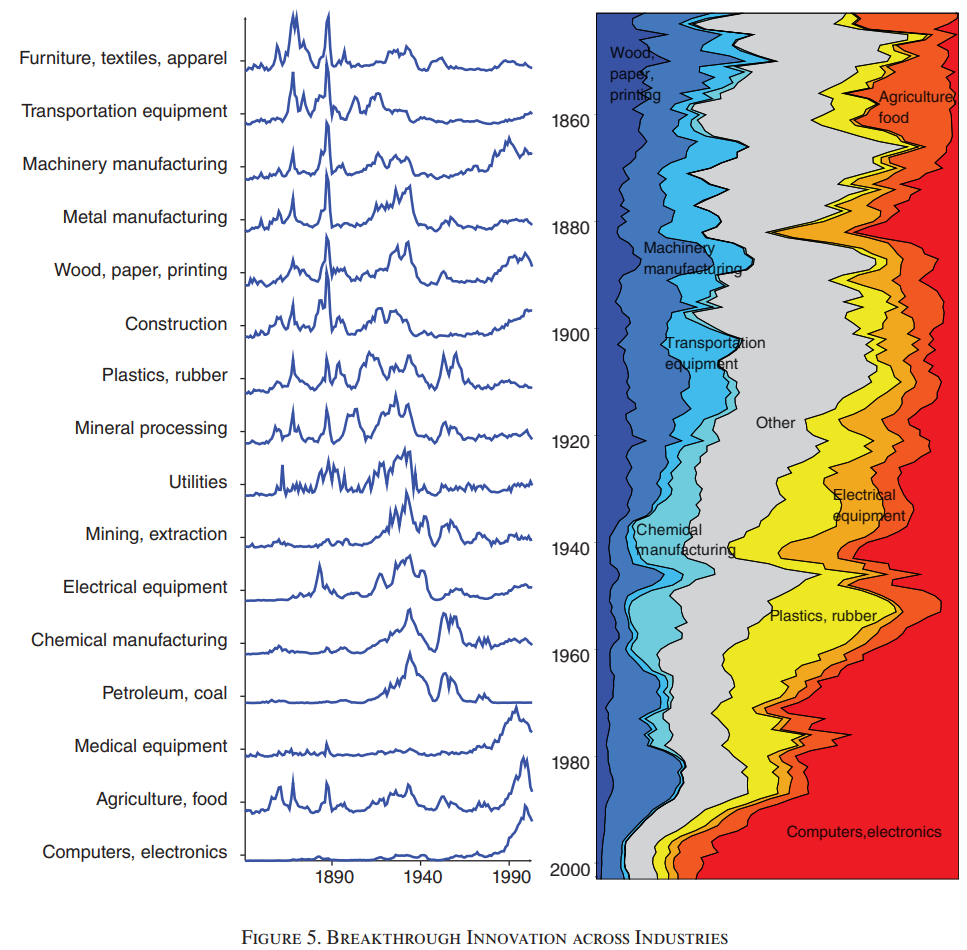

### Unsupervised text analysis

Unsupervised text analysis is a subset of Natural Language Processing (NLP) that involves the extraction of meaningful patterns or knowledge from a text corpus without the need for labeled data. It's called "unsupervised" because the algorithms discover these patterns on their own, without guidance from a 'supervisor', unlike supervised learning where you provide the algorithm with labeled data to learn from.

Unsupervised text analysis techniques are often used to discover hidden themes or topics in a corpus, to group or cluster documents, or to reduce the dimensionality of text data for further processing or visualization. Techniques can include clustering (such as K-means, hierarchical, or DBSCAN), dimensionality reduction (like PCA or t-SNE), or topic modeling (such as Latent Dirichlet Allocation or LDA).

#### Posterior approaches

We define posterior approaches as methods that analyse the document-term matrix after it has been created.

##### Principal Component Analysis

Let's start with PCA, a method that highlights the key variations in a high-dimensional dataset by creating new uncorrelated variables that successively maximize variance. We're using the PCA from sklearn.decomposition to reduce the dimensionality of our data. This is often done to help visualize the data, as visualizing high-dimensional data is a challenge.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')
Xpca = pca.fit_transform(X.toarray())
pca.explained_variance_ratio_

In [ ]:
# Visualisation
plt.scatter(Xpca[:,0],Xpca[:,1], alpha=.1)
plt.show()

Let's try in three dimensions, taking into account the first three principal components of our data. This allows for a deeper understanding of the spread and clustering in our data.

In [ ]:
# 3D Visualisation
from mpl_toolkits.mplot3d import Axes3D

# create 3D scatter plot from Xpca
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xpca[:, 0], Xpca[:, 1], Xpca[:, 2], alpha=.2)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show() 

t-SNE (t-Distributed Stochastic Neighbor Embedding) is another technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. It transforms high-dimensional data into a 2 or 3-dimensional space so that it can be visualized. Here, we're using sklearn.manifold.TSNE to perform t-SNE on our data, and visualizing the results using Altair.

In [ ]:
# t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=250)
Xtsne = tsne.fit_transform(X.toarray())

In [ ]:
plot_data = pd.merge(
    pd.DataFrame({'x': Xtsne[:, 0], 'y': Xtsne[:, 1]}),
    data[["publication_date", "abstract", "display_name"]],
    left_index=True,
    right_index=True
)

In [ ]:
alt.Chart(plot_data).mark_circle(size=60, opacity=0.3).encode(
    x=alt.X('x', scale=alt.Scale(domain=[-5, 5])),
    y=alt.Y('y', scale=alt.Scale(domain=[-5, 5])),
    tooltip=['display_name']
).properties(
    width=600,
    height=600
).interactive()

Another approach to dimensionality reduction that uses the document-term matrix as input are traditional clustering algorithms. Let's explore some of the popular alternatives.

##### K-means clustering

In this step, we're applying K-means clustering to our data. K-means clustering is an iterative algorithm that divides a group of n datasets into k non-overlapping subsets or clusters, where each dataset belongs to the cluster with the nearest mean.

In [ ]:
from sklearn.cluster import KMeans
num_clusters = 20
km = KMeans(n_clusters=num_clusters, n_init='auto', random_state=42)
km.fit(X)
plot_data["kmeans"] = km.labels_.tolist()

In [ ]:
def clusters_plot(cluster_column):
    return alt.Chart(plot_data).mark_circle(size=60, opacity=0.3).encode(
        x=alt.X('x', scale=alt.Scale(domain=[-5, 5])),
        y=alt.Y('y', scale=alt.Scale(domain=[-5, 5])),
        color=f'{cluster_column}:N',
        tooltip=['display_name']
    ).properties(
        width=600,
        height=600
    ).interactive()

In [ ]:
clusters_plot("kmeans")

In order to define the number of clusters, a popular approach is to estimate the silhouette score for each option, and select the one with the highest value. Popular alternatives include the Elbow method (plot the distance to centroids at each choice of n_clusters and select the one whose subsequent improvement is smallest), or the Gap Statistic (a more nuanced approach to the Elbow method).

Note this can be somewhat slow for a granular search over the optimal number of clusters. If you want to run it, convert the cell to Python before. 

##### Agglomerative Clustering

This is another method of hierarchical clustering that builds a hierarchy of clusters by merging together small clusters. It starts by treating each object as a singleton cluster, then pairs up clusters with the smallest distance between them, and continues until only a single cluster remains.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=20, metric='euclidean', linkage='ward')
cluster.fit_predict(X.toarray())

plot_data["hclust"] = cluster.labels_

In [ ]:
clusters_plot("hclust")

##### DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm, where clusters are defined as areas of higher density than the remainder of the dataset. Unlike K-means, DBSCAN doesn't require the user to specify the number of clusters. Instead, it infers the number of clusters based on the data, separating areas of high density from areas of low density. This can be particularly useful for discovering clusters of unusual shape.

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.95, min_samples=5)
dbscan.fit(X.toarray())
plot_data["dbscan"] = dbscan.labels_

In [ ]:
clusters_plot("dbscan")